In [1]:
from datasets import load_dataset
import pandas as pd
import re
import json

# Load dataset
ds = load_dataset("AGBonnet/augmented-clinical-notes")
df = ds["train"].to_pandas()  # Convert to pandas DataFrame for easier manipulation

In [2]:
from snorkel.labeling import labeling_function

# Define pulmonary keywords (ICD-10 inspired)
PULMONARY_TERMS = {
    "asthma", "copd", "pneumonia", "pulmonary fibrosis", "bronchitis",
    "tuberculosis", "lung cancer", "emphysema", "pneumothorax",
    "cystic fibrosis", "ARDS", "pulmonary embolism", "chronic bronchitis"
}

# Define regex patterns for variations (e.g., "COPD exacerbation")
PULMONARY_REGEX = re.compile(
    r'('
    r'\b(asthma|asthmatic|bronchial asthma)\b|'
    r'\b(COPD|chronic obstructive pulmonary disease|chronic obstructive lung disease)\b|'
    r'\b(pneumonia|CAP|HAP|VAP|community-acquired pneumonia|hospital-acquired pneumonia|ventilator-associated pneumonia)\b|'
    r'\b(pulmonary embolism|PE|pulmonary thromboembolism)\b|'
    r'\b(tuberculosis|TB|mycobacterium tuberculosis|pulmonary TB)\b|'
    r'\b(lung cancer|lung carcinoma|bronchogenic carcinoma|NSCLC|SCLC|non-small cell lung cancer|small cell lung cancer)\b|'
    r'\b(bronchitis|acute bronchitis|chronic bronchitis)\b|'
    r'\b(pulmonary fibrosis|idiopathic pulmonary fibrosis|IPF)\b|'
    r'\b(cystic fibrosis|CF)\b|'
    r'\b(pneumothorax|collapsed lung)\b|'
    r'\b(ARDS|acute respiratory distress syndrome)\b|'
    r'\b(emphysema|pulmonary emphysema)\b|'
    r'\b(interstitial lung disease|ILD)\b|'
    r'\b(pulmonary hypertension|PH)\b|'
    r'\b(pleural effusion|hydrothorax)\b|'
    r'\b(silicosis|occupational lung disease)\b|'
    r'\b(COVID-19|SARS-CoV-2|coronavirus)\b'
    r')', 
    flags=re.IGNORECASE  # Match case-insensitively
)

# Labeling Function 1: Check structured JSON summary for diagnoses
@labeling_function()
def lf_summary_diagnosis(row):
    try:
        summary = json.loads(row["summary"])
        diagnoses = summary.get("diagnosis", [])
        # Ensure diagnoses is a list
        if not isinstance(diagnoses, list):
            diagnoses = [diagnoses]
        for d in diagnoses:
            if any(term in d.lower() for term in PULMONARY_TERMS):
                return 1
    except Exception as e:
        pass
    return 0  # non-pulmonary

# Labeling Function 2: Keyword search in notes
@labeling_function()
def lf_note_keywords(row):
    note_text = ((row.get("note") or "") + " " + (row.get("full_note") or "")).lower()
    if any(term in note_text for term in PULMONARY_TERMS):
        return 1
    return 0

# Improved negation-aware regex (checks for negation near pulmonary terms)
NEGATION_REGEX = re.compile(
    r'\b(no history of|ruled out|denies|negative for|no|without)\b\s*'  # Negation trigger
    r'(?:\w+\s+){0,5}'  # Allow up to 5 words between negation and pulmonary term
    r'(' + PULMONARY_REGEX.pattern + r')',  # Pulmonary terms from your regex
    flags=re.IGNORECASE
)

@labeling_function()
def lf_note_regex(row):
    note_text = row["note"] + " " + row["full_note"]
    # Check for pulmonary terms
    pulmonary_match = PULMONARY_REGEX.search(note_text)
    if not pulmonary_match:
        return 0  # No pulmonary term found
    
    # Check if the pulmonary term is negated
    if NEGATION_REGEX.search(note_text):
        return 0  # Pulmonary term is negated
    return 1  # Pulmonary term is affirmed

In [3]:
from snorkel.labeling import PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel

# Combine labeling functions
lfs = [lf_summary_diagnosis, lf_note_keywords, lf_note_regex]

# Apply labeling functions to the DataFrame using Snorkel's PandasLFApplier
applier = PandasLFApplier(lfs)
L_train = applier.apply(df)

# Analyze LF performance (coverage, conflicts)
analysis = LFAnalysis(L_train, lfs)
analysis.lf_summary()  # This prints a summary of your labeling functions

# Train a LabelModel to combine LF outputs
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train, n_epochs=500, log_freq=100)

# Predict probabilistic labels; here, tie_break_policy="abstain" will mark ties as abstentions (-1)
df["label_pulmonary"] = label_model.predict(L_train, tie_break_policy="abstain")

# Filter for pulmonary cases (label == 1)
pulmonary_df = df[df["label_pulmonary"] == 1].reset_index(drop=True)

# Optionally, inspect the results
print("Pulmonary cases:", len(pulmonary_df))

100%|██████████| 30000/30000 [00:48<00:00, 622.31it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
 17%|█▋        | 86/500 [00:00<00:00, 857.83epoch/s]INFO:root:[100 epochs]: TRAIN:[loss=0.007]
INFO:root:[200 epochs]: TRAIN:[loss=0.000]
100%|██████████| 500/500 [00:00<00:00, 1203.09epoch/s]
INFO:root:Finished Training


Pulmonary cases: 5744


In [4]:
# Display a random sample of rows
print(df[['note', 'summary', 'label_pulmonary']].sample(10))


                                                    note  \
12486  A 74-year-old man was referred to our departme...   
2143   A 30-year-old adult male presented to the trau...   
5811   An 18-year-old healthy man presented to the em...   
20132  A 26-year-old man was referred to the hospital...   
5991   We present the case of a 66-year-old man who p...   
10990  A 22-year-old male patient presented to our de...   
21409  A 22-year-old female presented with the New Yo...   
6177   A 55-year-old man with a 28-year history of di...   
26458  A previously healthy 79-year-old man with epig...   
28666  A 73-year-old Asian woman with an underlying a...   

                                                 summary  label_pulmonary  
12486  {\n"visit motivation": "Recurrent sinusitis an...                0  
2143   {\n"visit motivation": "Accidental fall follow...                0  
5811   {\n"visit motivation": "Right testicular pain ...                0  
20132  {\n"visit motivation": "Eval

In [5]:
# Define regex patterns for target conditions
CONDITION_REGEX = {
    "Asthma": re.compile(
        r'\b(asthma|asthmatic|bronchial asthma)\b', 
        flags=re.IGNORECASE
    ),
    "COPD": re.compile(
        r'\b(COPD|chronic obstructive pulmonary disease|chronic obstructive lung disease|emphysema|chronic bronchitis)\b', 
        flags=re.IGNORECASE
    ),
    "Pneumonia": re.compile(
        r'\b(pneumonia|CAP|HAP|VAP|community-acquired pneumonia|hospital-acquired pneumonia|ventilator-associated pneumonia)\b', 
        flags=re.IGNORECASE
    ),
    "Lung Cancer": re.compile(
        r'\b(lung cancer|lung carcinoma|bronchogenic carcinoma|NSCLC|SCLC|non-small cell lung cancer|small cell lung cancer)\b', 
        flags=re.IGNORECASE
    ),
    "Tuberculosis": re.compile(
        r'\b(tuberculosis|TB|mycobacterium tuberculosis|pulmonary TB)\b', 
        flags=re.IGNORECASE
    ),
    "Pleural Effusion": re.compile(
        r'\b(pleural effusion|hydrothorax)\b', 
        flags=re.IGNORECASE
    )
}

# Negation regex (improved to check proximity to condition terms)
NEGATION_REGEX = re.compile(
    r'\b(no history of|ruled out|denies|negative for|no|without)\b\s*'  # Negation trigger
    r'(?:\w+\s+){0,5}'  # Allow up to 5 words between negation and condition
    r'(' + '|'.join([pattern.pattern for pattern in CONDITION_REGEX.values()]) + r')',  # Combined condition terms
    flags=re.IGNORECASE
)

def get_condition_labels(row):
    note_text = row["note"] + " " + row["full_note"]
    labels = []
    
    # Check for negations first
    negation_match = NEGATION_REGEX.search(note_text)
    
    for condition, pattern in CONDITION_REGEX.items():
        # Skip if the condition term is negated
        if negation_match and pattern.search(negation_match.group(0)):
            continue
        # Check if condition is mentioned
        if pattern.search(note_text):
            labels.append(condition)
    
    return labels

# Apply labeling to pulmonary cases
pulmonary_df["conditions"] = pulmonary_df.apply(get_condition_labels, axis=1)

# Classify remaining cases as "Other Pulmonary"
pulmonary_df["conditions"] = pulmonary_df["conditions"].apply(
    lambda x: x if x else ["Other Pulmonary"]
)

In [6]:
from collections import defaultdict

label_counts = defaultdict(int)
for labels in pulmonary_df["conditions"]:
    for label in labels:
        label_counts[label] += 1

print("Label distribution:")
for k, v in label_counts.items():
    print(f"{k}: {v}")

Label distribution:
Asthma: 509
Pneumonia: 1294
Other Pulmonary: 1907
Tuberculosis: 851
Pleural Effusion: 743
COPD: 697
Lung Cancer: 415


C:\Users\richa\AppData\Local\Temp\ipykernel_32404\3450995604.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Condition", y="Count", data=df_counts, palette="viridis")


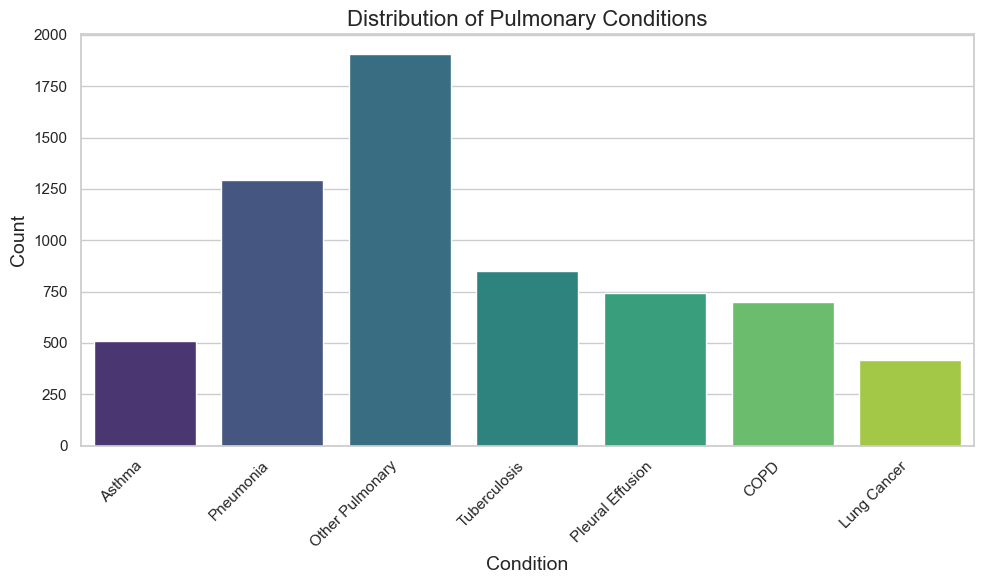

In [7]:
import pandas as pd

# Label distribution data
label_counts = {
    "Asthma": 509,
    "Pneumonia": 1294,
    "Other Pulmonary": 1907,
    "Tuberculosis": 851,
    "Pleural Effusion": 743,
    "COPD": 697,
    "Lung Cancer": 415
}

# Convert to DataFrame for easier plotting
df_counts = pd.DataFrame(list(label_counts.items()), columns=["Condition", "Count"])

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Condition", y="Count", data=df_counts, palette="viridis")

# Add labels and title
plt.title("Distribution of Pulmonary Conditions", fontsize=16)
plt.xlabel("Condition", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability

# Show plot
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\richa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


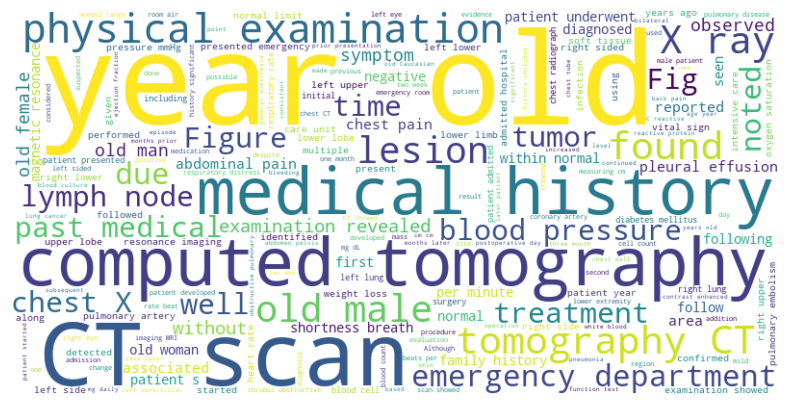

In [8]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Download stop words from nltk (do this once)
nltk.download('stopwords')

# Get the list of stop words
stop_words = set(stopwords.words('english'))

# Combine all notes into one large string
text = " ".join(pulmonary_df['note'].dropna())  # Combine all notes into a single string

# Tokenize the text and remove stop words
filtered_words = [word for word in text.split() if word.lower() not in stop_words]

# Join the filtered words back into a single string
cleaned_text = " ".join(filtered_words)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, stop_words="english",ngram_range=(1, 2))  
X = vectorizer.fit_transform(pulmonary_df['note'])  # Note column


In [10]:
#Transform Object data type to string
pulmonary_df["conditions"] = pulmonary_df["conditions"].apply(lambda x: x[0])

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, pulmonary_df['conditions'], test_size=0.1, random_state=42)

#Logistic Regression Classification Report
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred_before_smote = model.predict(X_test)
print(classification_report(y_test, y_pred_before_smote))
report_before_smote = classification_report(y_test, y_pred_before_smote, output_dict=True)

                  precision    recall  f1-score   support

          Asthma       0.95      0.54      0.69        37
            COPD       0.96      0.77      0.86        66
     Lung Cancer       0.71      0.57      0.63        35
 Other Pulmonary       0.62      0.90      0.73       189
Pleural Effusion       0.89      0.62      0.73        50
       Pneumonia       0.74      0.65      0.69       130
    Tuberculosis       0.68      0.47      0.56        68

        accuracy                           0.71       575
       macro avg       0.79      0.65      0.70       575
    weighted avg       0.74      0.71      0.71       575



In [11]:
from imblearn.over_sampling import SMOTE

# Logistic Regression after SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
model.fit(X_train_res, y_train_res)
y_pred_after_smote = model.predict(X_test)
print(classification_report(y_test, y_pred_after_smote))
report_after_smote = classification_report(y_test, y_pred_after_smote, output_dict=True)


                  precision    recall  f1-score   support

          Asthma       0.90      0.76      0.82        37
            COPD       0.95      0.82      0.88        66
     Lung Cancer       0.59      0.74      0.66        35
 Other Pulmonary       0.74      0.78      0.76       189
Pleural Effusion       0.76      0.74      0.75        50
       Pneumonia       0.71      0.65      0.68       130
    Tuberculosis       0.58      0.66      0.62        68

        accuracy                           0.73       575
       macro avg       0.75      0.74      0.74       575
    weighted avg       0.74      0.73      0.74       575



In [12]:
# Convert y_resampled to a pandas Series to get the distribution
y_resampled = pd.Series(y_train_res)

# Get class distribution after SMOTE
label_counts_smote = y_resampled.value_counts()

print("Label distribution after SMOTE:")
print(label_counts_smote)


Label distribution after SMOTE:
conditions
Pneumonia           1718
Asthma              1718
COPD                1718
Other Pulmonary     1718
Tuberculosis        1718
Pleural Effusion    1718
Lung Cancer         1718
Name: count, dtype: int64


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from prettytable import PrettyTable
import pandas as pd

# Split the data before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, pulmonary_df['conditions'], test_size=0.3, random_state=42)

# Train Random Forest without SMOTE
rf_model_before_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_before_smote.fit(X_train, y_train)

# Make Predictions
y_pred_before_smote = rf_model_before_smote.predict(X_test)

# Generate classification report
report_before_smote = classification_report(y_test, y_pred_before_smote, output_dict=True)

# Convert to DataFrame
df_report_before_smote = pd.DataFrame(report_before_smote).transpose()

# Use PrettyTable for a more structured look
table_before_smote = PrettyTable()
table_before_smote.field_names = ["Class", "Precision", "Recall", "F1-Score", "Support"]

for index, row in df_report_before_smote.iterrows():
    table_before_smote.add_row([index, round(row['precision'], 2), round(row['recall'], 2), round(row['f1-score'], 2), int(row['support'])])

print(table_before_smote)


+------------------+-----------+--------+----------+---------+
|      Class       | Precision | Recall | F1-Score | Support |
+------------------+-----------+--------+----------+---------+
|      Asthma      |    0.98   |  0.82  |   0.89   |   154   |
|       COPD       |    0.97   |  0.88  |   0.92   |   191   |
|   Lung Cancer    |    0.85   |  0.68  |   0.76   |   100   |
| Other Pulmonary  |    0.67   |  0.93  |   0.78   |   548   |
| Pleural Effusion |    0.81   |  0.79  |   0.8    |   156   |
|    Pneumonia     |    0.91   |  0.7   |   0.79   |   354   |
|   Tuberculosis   |    0.8    |  0.57  |   0.66   |   221   |
|     accuracy     |    0.79   |  0.79  |   0.79   |    0    |
|    macro avg     |    0.85   |  0.77  |   0.8    |   1724  |
|   weighted avg   |    0.82   |  0.79  |   0.79   |   1724  |
+------------------+-----------+--------+----------+---------+


In [14]:
# %pip install prettytable
from prettytable import PrettyTable

#Random Forest Now Model with SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, pulmonary_df['conditions'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make Predictions
y_pred = rf_model.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert to DataFrame
df_report = pd.DataFrame(report).transpose()

# Use PrettyTable for a more structured look
table = PrettyTable()
table.field_names = ["Class", "Precision", "Recall", "F1-Score", "Support"]

for index, row in df_report.iterrows():
    table.add_row([index, round(row['precision'], 2), round(row['recall'], 2), round(row['f1-score'], 2), int(row['support'])])

print(table)


+------------------+-----------+--------+----------+---------+
|      Class       | Precision | Recall | F1-Score | Support |
+------------------+-----------+--------+----------+---------+
|      Asthma      |    0.99   |  0.97  |   0.98   |   580   |
|       COPD       |    0.99   |  0.95  |   0.97   |   569   |
|   Lung Cancer    |    0.94   |  0.99  |   0.96   |   582   |
| Other Pulmonary  |    0.8    |  0.9   |   0.85   |   572   |
| Pleural Effusion |    0.96   |  0.97  |   0.96   |   579   |
|    Pneumonia     |    0.97   |  0.83  |   0.89   |   566   |
|   Tuberculosis   |    0.93   |  0.94  |   0.94   |   557   |
|     accuracy     |    0.94   |  0.94  |   0.94   |    0    |
|    macro avg     |    0.94   |  0.94  |   0.94   |   4005  |
|   weighted avg   |    0.94   |  0.94  |   0.94   |   4005  |
+------------------+-----------+--------+----------+---------+


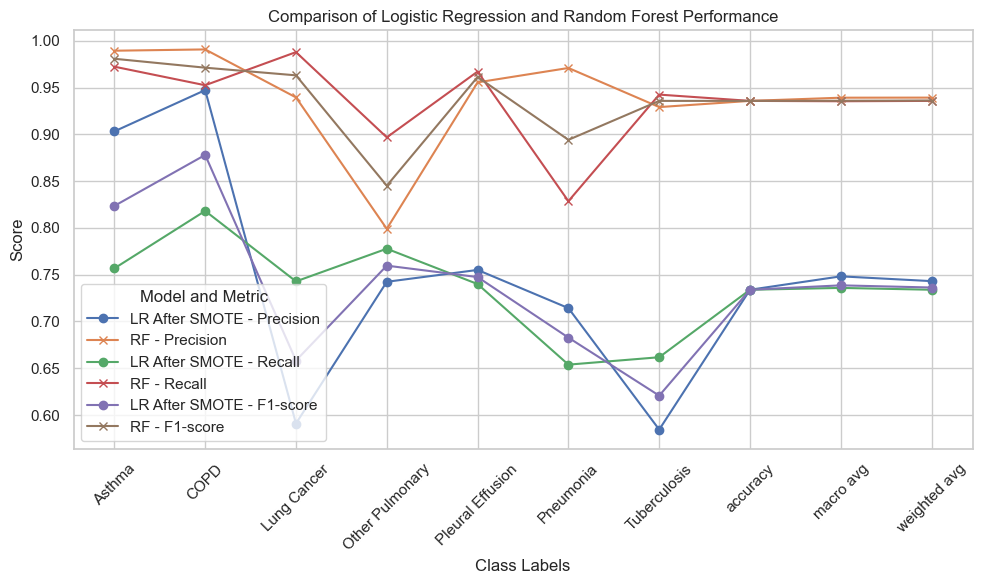

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming report_after_smote and df_report are already generated as DataFrames

# Convert the necessary columns to DataFrame for easy plotting
df_lr = pd.DataFrame(report_after_smote).transpose()  # Logistic Regression after SMOTE
df_rf = pd.DataFrame(report).transpose()  # Random Forest

# Extract relevant columns (precision, recall, and f1-score)
metrics = ['precision', 'recall', 'f1-score']

# Set up the figure for the plot
plt.figure(figsize=(10, 6))

# Plot for each metric
for metric in metrics:
    plt.plot(df_lr.index, df_lr[metric], label=f'LR After SMOTE - {metric.capitalize()}', marker='o')
    plt.plot(df_rf.index, df_rf[metric], label=f'RF - {metric.capitalize()}', marker='x')

# Add labels and title
plt.title('Comparison of Logistic Regression and Random Forest Performance')
plt.xlabel('Class Labels')
plt.ylabel('Score')
plt.legend(title="Model and Metric")

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.utils import resample

#Separate majority and minority classes
grouped = pulmonary_df.groupby("Conditions")
max_size = grouped.size().max()

#Oversample each class to the same count as the majority class
oversampled_df = grouped.apply(
    lambda x: resample(x, replace=True, n_samples=max_size, random_state=42)
    
).reset_index(drop=True)

print(oversampled_df["conditions"].value_counts())



conditions
Asthma              1907
COPD                1907
Lung Cancer         1907
Other Pulmonary     1907
Pleural Effusion    1907
Pneumonia           1907
Tuberculosis        1907
Name: count, dtype: int64


C:\Users\richa\AppData\Local\Temp\ipykernel_32404\2391357145.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  oversampled_df = grouped.apply(


In [ ]:
from datasets import Dataset
from transformers import AutoTokenizer

dataset = Dataset.from_pandas(oversampled_df)

# Tokenize using ClinicalBERT
model_checkpoint = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(example):
    return tokenizer(example["note"], truncation=True, padding="max_length", max_length=512)

tokenized_dataset = dataset.map(tokenize_function, batched=True)

# Label encoding 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
tokenized_dataset = tokenized_dataset.add_column("label", label_encoder.fit_transform(tokenized_dataset["conditions"]))

# Final formatting
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/13349 [00:00<?, ? examples/s]

In [ ]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 4070 Laptop GPU


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments

# Split dataset
split_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

# Load model checkpoint and tokenizer
model_checkpoint = "emilyalsentzer/Bio_ClinicalBERT"  # or your intended base model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Load model with the correct number of classes
num_classes = len(label_encoder.classes_)
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_classes
)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

# Define evaluation metrics
def compute_metrics(p):
    preds = p.predictions.argmax(axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Save the model and tokenizer
trainer.save_model("./trained_clinicalbert")
tokenizer.save_pretrained("./trained_clinicalbert")

# Evaluate the model
trainer.evaluate()


C:\Users\richa\AppData\Local\Temp\ipykernel_18760\1470510061.py:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'eval_loss': 0.16630546748638153,
 'eval_model_preparation_time': 0.0022,
 'eval_accuracy': 0.9722846441947566,
 'eval_f1': 0.9720142646338108,
 'eval_precision': 0.9721941307124695,
 'eval_recall': 0.9722846441947566,
 'eval_runtime': 21.0265,
 'eval_samples_per_second': 63.491,
 'eval_steps_per_second': 7.942}

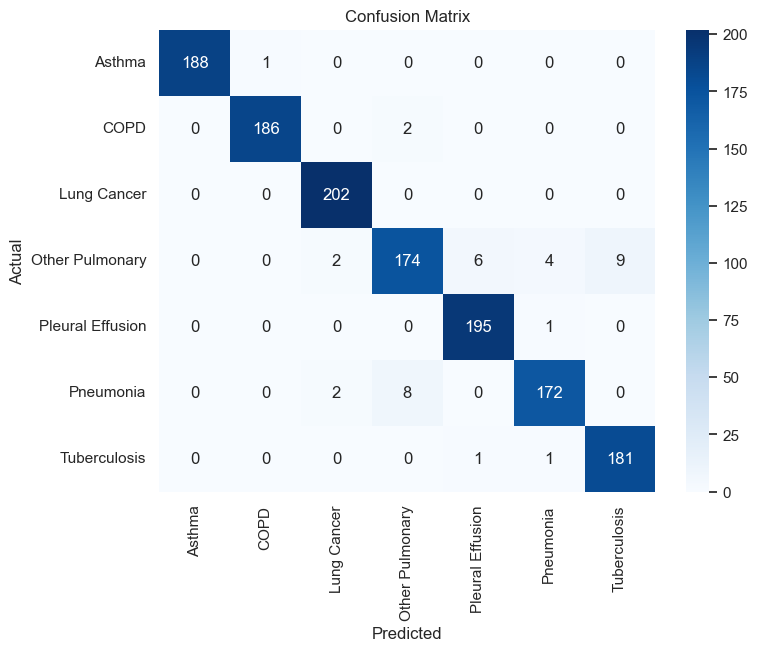

                  precision    recall  f1-score   support

          Asthma       1.00      0.99      1.00       189
            COPD       0.99      0.99      0.99       188
     Lung Cancer       0.98      1.00      0.99       202
 Other Pulmonary       0.95      0.89      0.92       195
Pleural Effusion       0.97      0.99      0.98       196
       Pneumonia       0.97      0.95      0.96       182
    Tuberculosis       0.95      0.99      0.97       183

        accuracy                           0.97      1335
       macro avg       0.97      0.97      0.97      1335
    weighted avg       0.97      0.97      0.97      1335



In [ ]:
predictions_output = trainer.predict(eval_dataset)
y_pred = predictions_output.predictions.argmax(axis=1)
y_prob = predictions_output.predictions  # softmax scores (for ROC/AUC)
y_true = predictions_output.label_ids

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report (includes F1, Precision, Recall per class)
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


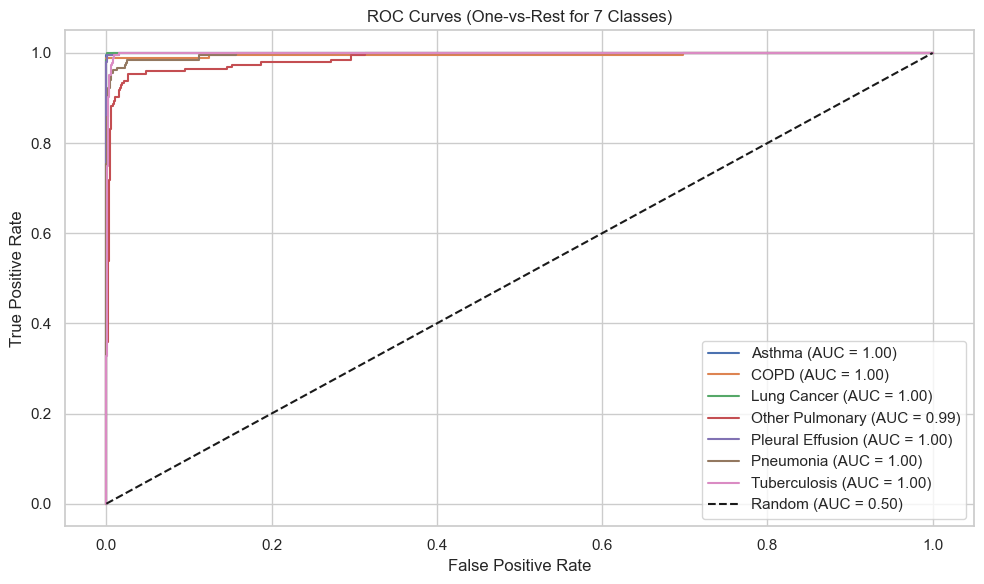

In [ ]:
from sklearn.preprocessing import label_binarize
from scipy.special import softmax


# Apply softmax to get probabilities
y_probs = softmax(y_prob, axis=1)

# Binarize the true labels for multi-class ROC (One-vs-Rest)
y_true_bin = label_binarize(y_true, classes=list(range(len(label_encoder.classes_))))

# Plot ROC curve per class
plt.figure(figsize=(10, 6))

for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    auc_score = roc_auc_score(y_true_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {auc_score:.2f})")

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.50)")

# Plot formatting
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest for 7 Classes)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

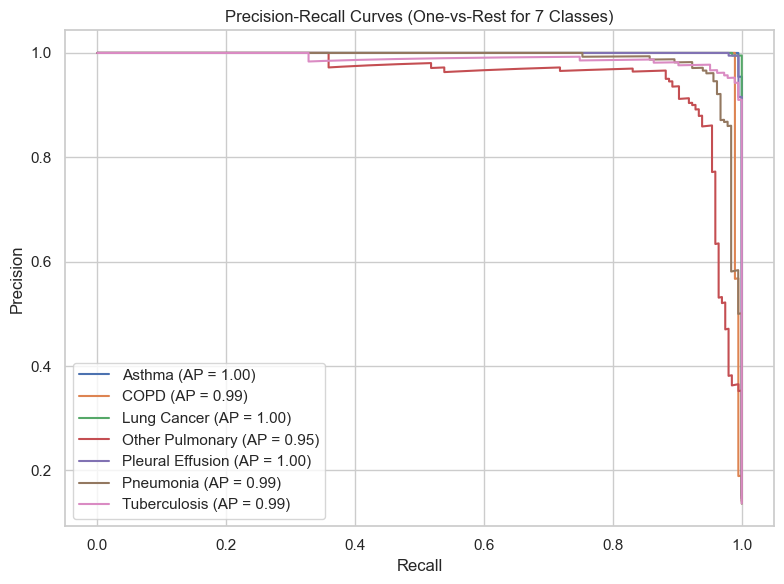

In [ ]:
#PR Curves

#Plot PR Curve per class
plt.figure(figsize=(8, 6))

for i, class_name in enumerate(label_encoder.classes_):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
    pr_auc = average_precision_score(y_true_bin[:, i], y_probs[:, i])
    plt.plot(recall, precision, label=f"{class_name} (AP = {pr_auc:.2f})")

# Plot formatting
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (One-vs-Rest for 7 Classes)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from scipy.special import softmax

# Sample clinical notes
demo_notes = [
    "Patient presents with high fever, chills, shortness of breath, and crackles heard on auscultation. Chest X-ray shows consolidation in the right lower lobe.",
    "Patient complains of chest tightness and wheezing that worsens at night and after physical activity. Symptoms relieved by use of albuterol inhaler.",
    "The patient is a 68-year-old male with a 40-pack-year smoking history who presents with worsening shortness of breath over the past 6 months. He reports a chronic productive cough that is worse in the mornings, occasional wheezing, and fatigue with mild exertion. On physical examination, breath sounds are diminished bilaterally with prolonged expiratory phase. Pulmonary function tests show reduced FEV1/FVC ratio consistent with obstructive lung disease. There are no signs of active infection. He denies fever or chills. Chest X-ray reveals hyperinflated lungs and flattened diaphragms.",
    "Patient has persistent cough, night sweats, weight loss, and hemoptysis. Sputum test positive for acid-fast bacilli.",
    "Patient presents with shortness of breath and pleuritic chest pain. Physical exam shows decreased breath sounds and dullness to percussion on the left side. Ultrasound confirms fluid accumulation."
]

# Predict function
def batch_predict(notes, model, tokenizer, label_encoder):
    predictions = []
    for note in notes:
        inputs = tokenizer(note, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
        inputs = {key: val.to(model.device) for key, val in inputs.items()}
        outputs = model(**inputs)
        probs = softmax(outputs.logits.detach().cpu().numpy(), axis=1)
        pred_idx = probs.argmax(axis=1)[0]
        pred_class = label_encoder.inverse_transform([pred_idx])[0]
        confidence = probs[0][pred_idx]
        predictions.append((pred_class, round(float(confidence), 4)))
    return predictions

# Create DataFrame
demo_df = pd.DataFrame({"Clinical Note": demo_notes})
demo_df[["Predicted Label", "Confidence"]] = batch_predict(demo_notes, model, tokenizer, label_encoder)

# View table
demo_df


,Clinical Note,Predicted Label,Confidence
0,"Patient presents with high fever, chills, shor...",Pneumonia,0.6453
1,Patient complains of chest tightness and wheez...,COPD,0.4386
2,The patient is a 68-year-old male with a 40-pa...,COPD,0.9887
3,"Patient has persistent cough, night sweats, we...",Tuberculosis,0.4724
4,Patient presents with shortness of breath and ...,Pleural Effusion,0.9775


In [ ]:
import gradio as gr

# Extract class names dynamically from the DataFrame
classes = sorted(oversampled_df["conditions"].unique().tolist())

# Load model and tokenizer
model_path = "trained_clinicalbert"
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prediction function
def predict_clinical_note(note):
    inputs = tokenizer(note, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probs = softmax(outputs.logits.cpu().numpy(), axis=1)
    pred_idx = probs.argmax(axis=1)[0]
    pred_class = classes[pred_idx]
    confidence = float(probs[0][pred_idx])
    return f"{pred_class} (Confidence: {confidence:.2f})"

# Gradio interface
iface = gr.Interface(
    fn=predict_clinical_note,
    inputs=gr.Textbox(lines=6, placeholder="Paste clinical note here..."),
    outputs="text",
    title="Pulmonary Disease Classifier",
    description="Enter a clinical note to predict pulmonary condition (e.g., COPD, Pneumonia, Tuberculosis...)"
)

if __name__ == "__main__":
    iface.launch()


* Running on local URL:  http://127.0.0.1:7860


INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://127.0.0.1:7860/gradio_api/startup-events "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7860/ "HTTP/1.1 200 OK"



To create a public link, set `share=True` in `launch()`.
